# Package and Parameter Preparing

In [67]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import os

In [69]:
# data parameter setting
tte_path = '../data/data_tte'
lob_path = '../data/data_lob'

time_span = 100
level_span = 10
train_val_ratio = 0.8

batch_size = 64

# cnn_lstm parameter setting

filter_num = 32
time_y = 10

# MLP parameter setting

hidden_size1 = 50
hidden_size2 = 20

# forward parameter setting

epochs =50
time_y = 10
learning_rate = 0.001
censor_weight = 0.1
time_weight = 1
input_size = 102



# Data processing

In [70]:
# data processing function
# ---------------------------------------------------------------------
def prepare_order(data, time_span, level_span, trans):
    [N, D] = data.shape
    # N:time num D:feature num
    df = np.array(data)
    if trans == True:
        df = (df - df.mean())/(df.std())

    # 3 dims: sample,time,feature
    dataX = np.zeros((N - time_span, time_span, 4*level_span))

    for i in range(time_span, N):
        dataX[i - time_span] = df[i - time_span:i, 0:4*level_span]

    return dataX


def prepare_timex(mess_data, order_index, time_span):
    # mess_data = np.array(mess_data)
    index_list = map(int, mess_data[:,0])
    # index_list = int(mess_data[:,0])

    time_feature = [order_index[i-time_span] for i in index_list]

    return np.array(time_feature)


def prepare_prex(mess_data,trans):
    # mess_data = np.array(mess_data)

    pre_feature = mess_data[:,4:]
    if trans == True:
        pre_feature = (pre_feature - pre_feature.mean())/(pre_feature.std())

    return pre_feature

def prepare_sub_prex(mess_data, lob_mess_data, trans):
    mess_data = np.array(mess_data)
    lob_mess_data = np.array(lob_mess_data)
    index_list = map(int, mess_data[:,0])

    pre_sub_feature = [lob_mess_data[i,3:5] for i in index_list]
    pre_sub_feature = np.array(pre_sub_feature)
    if trans == True:
        pre_sub_feature = (pre_sub_feature - pre_sub_feature.mean())/(pre_sub_feature.std())
    return pre_sub_feature
    



    

In [71]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, mess_data, order_data, lob_mess_data, time_span, level_span, trans):
        """Initialization""" 
        self.time_span = time_span
        self.level_span = level_span
            
        # trans the order data into 4 dim data 
        order_index = prepare_order(order_data, time_span, level_span, trans)

        # according the message in mess_data to get the time feature
        time_feature = prepare_timex(mess_data, order_index, time_span)

        # according the message in mess_data to get the present feature
        pre_feature = prepare_prex(mess_data, trans)

        # according the order submission information in lob_mess_data to get another present feature
        pre_sub_feature = prepare_sub_prex(mess_data, lob_mess_data, trans)

        # get the time and censor label
        y = mess_data[:,1:3]

        if trans==True:
            a = y[:,0]
            # b = np.log(y[:,1])
            b = y[:,1]
            b = (b - b.mean())/(b.std())
            a = np.expand_dims(a,axis=1)
            b = np.expand_dims(b,axis=1)
            y = np.concatenate((a,b),axis=1)
        # len(x) get the sample num
        self.length = len(mess_data)

        time_feature = torch.from_numpy(time_feature)
        self.time_feature = torch.unsqueeze(time_feature, 1)
        self.pre_feature = torch.from_numpy(pre_feature)
        self.pre_sub_feature = torch.from_numpy(pre_sub_feature)
        self.y = torch.from_numpy(y)
        self.pre_feature = torch.concat((self.pre_feature,self.pre_sub_feature),1)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        # we can return three parameters
        return self.time_feature[index], self.pre_feature[index], self.y[index]

In [77]:
# iterate the file and get dataset list
file_name = os.listdir(tte_path)
print(np.floor(len(file_name)*0.8))
print(int(np.floor(len(file_name) * train_val_ratio)))
train_file = file_name[:int(np.floor(len(file_name) * train_val_ratio))]
val_file = file_name[int(np.floor(len(file_name) * train_val_ratio)):]
# mess_data = np.loadtxt(tte_path+'/'+train_file[0],skiprows=1,encoding='utf-8')
# train_file = ['34200_3900_NFLX_2017-05-01_tte.txt']
print(len(train_file))
print(len(val_file))
# train_data_list = []
train_dataloader_list = []
# val_data_list = []
val_dataloader_list = []
a=[]
b=[]
c=[]
d=[]
for i in train_file:
    order_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('orderbook_50.csv') ]
    mess_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('message_50.csv') ]
    a.append(order_file[0])
    b.append(mess_file[0])
for i in val_file:
    order_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('orderbook_50.csv') ]
    mess_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('message_50.csv') ]
    c.append(order_file[0])
    d.append(mess_file[0])
print(len(a))
print(len(b))
print(len(c))
print(len(d))

202.0
202
202
51
202
202
51
51


In [ ]:
mess_data = np.loadtxt("D:\Postgraduate_Course_Information\Director Peng\ML_Time_to_Execution\execution_torch_code\data\data_test_tte/34200_3900_NFLX_2017-05-02_tte.txt",skiprows=1)
index_list = map(int, mess_data[:,0])
order_data = np.loadtxt("D:\Postgraduate_Course_Information\Director Peng\ML_Time_to_Execution\execution_torch_code\data\data_test_lob/34200_3900_NFLX_2017-05-02_24900000_57900000_orderbook_50.csv",delimiter = ',')
for i in index_list:
    print(i)


In [112]:
a=torch.tensor([[],[],[]])
b=torch.tensor([[1,2,3],[3,4,5]])
c=torch.cat((a,b),1)
a.shape

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 2 for tensor number 1 in the list.

In [96]:
order_index = prepare_order(order_data, time_span, level_span, trans=True)

        # according the message in mess_data to get the time feature
time_feature = prepare_timex(mess_data, order_index, time_span)

In [97]:
print(time_feature.shape)
print(order_index.shape)

(26698, 100, 40)
(66958, 100, 40)


In [41]:
# train_data_list = []
train_dataloader_list = []
# val_data_list = []
val_dataloader_list = []


for i in train_file[0:2]:
    order_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('orderbook_50.csv') ]
    mess_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('message_50.csv') ]
    mess_data = np.loadtxt(tte_path+'/'+i,skiprows=1)
    order_data = np.loadtxt(lob_path+'/'+order_file[0],delimiter = ',')
    lob_mess_data = np.loadtxt(lob_path+'/'+mess_file[0],delimiter = ',')
    middle_dataset = Dataset(mess_data=mess_data,order_data=order_data,lob_mess_data=lob_mess_data,time_span=time_span,level_span=level_span,trans=True)
    middle_dataloader = torch.utils.data.DataLoader(dataset=middle_dataset, batch_size=batch_size, shuffle=True)
    train_dataloader_list.append(middle_dataloader)


for i in val_file[0:1]:
    order_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('orderbook_50.csv') ]
    mess_file = [name for name in os.listdir(lob_path) if name.startswith(i[:-8]) and name.endswith('message_50.csv') ]
    mess_data = np.loadtxt(tte_path+'/'+i,skiprows=1)
    order_data = np.loadtxt(lob_path+'/'+order_file[0],delimiter = ',')
    lob_mess_data = np.loadtxt(lob_path+'/'+mess_file[0],delimiter = ',')
    middle_dataset = Dataset(mess_data=mess_data,order_data=order_data,lob_mess_data=lob_mess_data,time_span=time_span,level_span=level_span,trans=True)
    middle_dataloader = torch.utils.data.DataLoader(dataset=middle_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader_list.append(middle_dataloader)

In [58]:
k=0
cnn_lstm_model = CNNLSTM(filter_num=filter_num, time_y=time_y)
data = train_dataloader_list[0]
for i in data:
    a,b,c=i
    print(a.shape)
    print(b.shape)
    print(c.shape)
    a=a.to(torch.float32)
    time_fea = cnn_lstm_model(a)
    fea = torch.cat((b,time_fea),dim=1) 
    print(fea.shape)
    k=k+1
    if k==1:
        break
                

torch.Size([64, 1, 100, 40])
torch.Size([64, 27])
torch.Size([64, 2])
torch.Size([64, 37])


In [53]:
# device figuragtion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
# input dim = (batch size, time, feature)
class CNNLSTM(nn.Module):
    def __init__(self, filter_num, time_y):
        super().__init__()
        self.time_y = time_y
        # convolution blocks
        # input dimension , output dimension = 4

        #(N,1,100,40)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filter_num, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#           nn.Tanh()
            nn.BatchNorm2d(filter_num),
            nn.Conv2d(in_channels=filter_num, out_channels=filter_num, kernel_size=(4,1), stride=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(filter_num),
        )
        #(N,32,100,20)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=filter_num, out_channels=filter_num, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(filter_num),
            nn.Conv2d(in_channels=filter_num, out_channels=filter_num, kernel_size=(4,1), stride=(1,1), padding='same'),
            nn.Tanh(),
            nn.BatchNorm2d(filter_num)
        )

        #(N,32,100,20)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=filter_num, out_channels=filter_num, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(filter_num)
        )
        
        # inception moduels

        #(N,32,100,1)
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        #(N,32,100,1)
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        #(N,32,100,1)
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers

        # (N,100,192)
        self.lstm = nn.LSTM(input_size=filter_num*6, hidden_size=64, num_layers=1, batch_first=True)
        # (N,100,64)
        self.fc1 = nn.Linear(64, self.time_y)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        # (N,192,100,1)
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        # (N,100,192,1)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        # (N,100,192)
        x, _ = self.lstm(x, (h0, c0))

        # (N,100,64)
        x = x[:,-1, :]
        # (N,1,64)
        x = torch.squeeze(x)
        # (N,64)
        middle_feature = self.fc1(x)
        # (N,10)
        # forecast_y = torch.softmax(x, dim=1)
        
        return middle_feature

In [55]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_size=2):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, num_size)
        self.norm1 = nn.BatchNorm1d(input_size)
        self.norm2 = nn.BatchNorm1d(hidden_size1)
        self.norm3 = nn.BatchNorm1d(hidden_size2)
        
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)

    def forward(self, x):
        out = self.norm1(x)
        out = self.l1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.norm3(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

In [37]:
# forward iteration parameter setting

criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()
cnn_lstm_model = CNNLSTM(filter_num=filter_num, time_y=time_y)
mlp_model = NeuralNet(input_size=time_y+27, hidden_size1=hidden_size1, hidden_size2=hidden_size2, num_size=2)
cnn_lstm_model.to(device)
mlp_model.to(device)
cnn_lstm_optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [38]:
# A function to encapsulate the training loop
def batch_gd(cnn_lstm_model, mlp_model, criterion1, criterion2, cnn_lstm_optimizer, mlp_optimizer,
 train_dataloader_list, val_dataloader_list, epochs):
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    best_val_loss = np.inf
    best_val_epoch = 0

    # same process epoch first and dataloader next
    for it in tqdm(range(epochs)):
        
        # start batch normalization and drop out
        cnn_lstm_model.train()
        mlp_model.train()

        t0 = datetime.now()
        train_loss = []
        for train_loader in train_dataloader_list:
            for time_fea, pre_fea, targets in train_loader:
                # move data to GPU
                time_fea, pre_fea, targets = time_fea.to(device, dtype=torch.float), pre_fea.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                censor_label = targets[:,0]
                time_label = targets[:,1]
                # print("inputs.shape:", inputs.shape)
                # zero the parameter gradients

                cnn_lstm_optimizer.zero_grad()
                mlp_optimizer.zero_grad()
                # Forward pass
                # print("about to get model output")
                time_fea = cnn_lstm_model(time_fea)
                fea = torch.cat((pre_fea,time_fea),dim=1) 
                

                y_predicted = mlp_model(fea)
                out1 = y_predicted[:, 0] 
                out2 = y_predicted[:, 1]
                loss1 = criterion1(out1, censor_label)
                loss2 = criterion2(out2, time_label)
                # print("done getting model output")
                # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
                loss = (censor_weight * loss1 + time_weight * loss2)
                train_loss.append(loss.item())
                # Backward and optimize
                # print("about to optimize")
                loss.backward()
                cnn_lstm_optimizer.step()
                mlp_optimizer.step()
                
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        # no drop out and the value in BN stays same
        cnn_lstm_model.eval()
        mlp_model.eval()
        val_loss = []
        for val_loader in val_dataloader_list:
            for time_fea, pre_fea, targets in val_loader:
                time_fea, pre_fea, targets = time_fea.to(device, dtype=torch.float), pre_fea.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)     
                censor_label = targets[:,0]
                time_label = targets[:,1]
                time_fea = cnn_lstm_model(time_fea)
                fea = torch.cat((pre_fea,time_fea),dim=1) 
                y_predicted = mlp_model(fea)
                out1 = y_predicted[:, 0] 
                out2 = y_predicted[:, 1]
                loss1 = criterion1(out1, censor_label)
                loss2 = criterion2(out2, time_label)
                # print("done getting model output")
                # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
                loss = (time_weight * loss1 + censor_weight * loss2)
                val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        # Save losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss
        
        if val_loss < best_val_loss:
            torch.save(cnn_lstm_model, '../model/cnn_lstm_model_pytorch')
            torch.save(mlp_model, './mlp_model_pytorch')
            best_val_loss = val_loss
            best_val_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {val_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_val_epoch}')

    return train_losses, val_losses

In [16]:
train_loader[0]

NameError: name 'train_loader' is not defined

In [39]:
train_losses, val_losses = batch_gd(cnn_lstm_model=cnn_lstm_model, mlp_model=mlp_model, criterion1=criterion1, criterion2=criterion2, 
  cnn_lstm_optimizer=cnn_lstm_optimizer, mlp_optimizer=mlp_optimizer,train_dataloader_list=train_dataloader_list, val_dataloader_list=val_dataloader_list, epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]D:\APP\Anaconda3\envs\Financial\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,
  2%|▏         | 1/50 [06:19<5:09:56, 379.53s/it]

model saved
Epoch 1/50, Train Loss: 1.0298,           Validation Loss: 18.7818, Duration: 0:06:19.524086, Best Val Epoch: 0


  2%|▏         | 1/50 [09:52<8:03:48, 592.42s/it]


KeyboardInterrupt: 

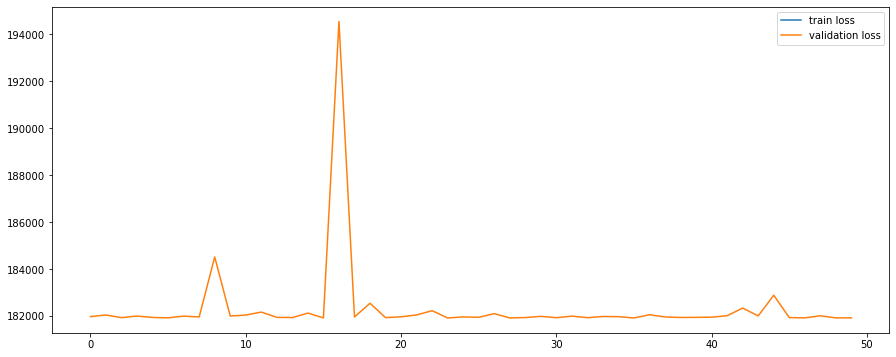

In [162]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
f = plt.gcf()
f.savefig('../picture/result.png')

In [230]:
a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
b = torch.tensor([1,2,3])
c = torch.cat((a,b),dim=1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 1